# OMNI Data Preprocess

## Data Description
Let's limit our analysis at the moment to the OMNI low res and high res output datasets, which contain measurements from ACE, WIND, IMP8, and Geotail spacecraft.

All of the data are in the high res set are averaged at 5 min intervals, which is quite a bit of data and difficult to work with given that most other datasets are given hourly. If we are able to compute 5 minute external field coefficients, then maybe we'll return to this dataset, but for now we will focus (as others have done) mostly on the hourly data. The hourly data are more likely to be production ready anyway, since 5 minute data feeds (to my knowledge) are unavailable, making this resolution unnecessary. 

For all vector quantities, we take the GSM coordinate system, which is most convenient for studying the effect of the measured magnetic field on Earth's magnetosphere and ionosphere. The X-direction is along the Earth-Sun ray, positive towards the sun. Z-direction is projection of Earth's dipole axis on the plane perpendicular to the X-direction, positive with magnetic North. The Y-direction completes the orthogonal left-handed coordinate system.

### Data columns
The data columns are described in detail [here](https://omniweb.gsfc.nasa.gov/html/HROdocum.html#4b) and [here](https://omniweb.gsfc.nasa.gov/html/ow_data.html#Availability). The hourly data currently of interest in our quest for prediction of Earth's magnetic response to space weather are
- IMF (interplanetary magnetic field)
- Solar wind speed
- Proton density (combined with wind speed, these form a dynamic pressure term)
- Alpha-Proton Density ratio (related and often used as an index for Interplanetary Coronal Mass Ejections, ICME)
- Sunspot number
- f10.7 solar index (strong indicator of solar activity, tracks frequencies originating in solar chromosphere and corona)

The data that we use are from 1998-2017, due to the excellent coverage and consistency from satellite measurements.

In [12]:
# general
import numpy as np
from sklearn import preprocessing
import os
import pdb
import datetime as dt
import warnings

# deep learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

# file management, io
import pandas as pd
import h5py

# plotting
import matplotlib.pyplot as plt
from scipy.stats import kde

## Load Data

Let's load the data in, which might require creating new hdf files.

### Create HDF files

HDF is way faster than other file formats, so we'll always work with these files for our purposes. The low-res data are in one spreadsheet, which we load in below using pandas and save to an hdf file. We'll also want to change the time to a python datetime, which requires converting yyyy-doy to a float using the function below. Note that these commands are only run if the hdf file doesn't already exist.

In [2]:
# check for existence of hdf file
fl = []
fls = os.listdir('../OMNI_data')
for s in fls:
    fl.append('omni_hourly_1998-2017.h5' == s)
    
# only if file doesn't exist, create it
if not any(fl):
    # load excel spreadsheet
    omni_lr_xls = pd.ExcelFile('../OMNI_data/omni_hourly_1998-2017.xlsx')
    omni_lr = pd.read_excel(omni_lr_xls)

    # function for transforming OMNI times to fractional ordinal python datetimes
    #
    # IN: time_data (integer array): with year, doy, hour, and minute in the 
    #      columns
    # OUT: t (flaot array): vector of ordinal dates 
    #
    def OMNI2python_date(time_data):
        nt = time_data.shape[0]
        t = np.zeros((nt,1))
        for ii in range(nt):
            curdate = dt.datetime(int(time_data[ii,0]),1,1).toordinal()
            curfrac =  dt.timedelta(days=time_data[ii,1]-1, \
                             hours=time_data[ii,2], \
                             minutes=time_data[ii,3])/dt.timedelta(1)
            t[ii] = curdate+curfrac
        return t

    # since the data is hourly, we add a vector of zeros for the minutes
    tOMNI = np.concatenate((omni_lr[['Year','DOY','Hour']].values, \
                            np.zeros((omni_lr.shape[0],1))),axis=1)
    t = OMNI2python_date(tOMNI)

    # add python time
    omni_lr = omni_lr.join(pd.Series(t[:,0],name='python time'))
    # reorder columns
    cols = omni_lr.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    omni_lr = omni_lr[cols]

    # save as hdf
    omni_lr.to_hdf('../OMNI_data/omni_hourly_1998-2017.h5','data')

### Read HDF files

Here we actually load data from the HDF5 files.

In [3]:
# load hdf file
omni_lr = pd.read_hdf('../OMNI_data/omni_hourly_1998-2017.h5')
# let's ignore the values from 2018 (just from January 1st)
omni_lr = omni_lr[omni_lr['Year'] != 2018]

# now split up data
yr = omni_lr['Year'].values
yr_unique = np.unique(yr)
nyr = len(yr_unique)
t = omni_lr['python time'].values

# here are all the measurements
data = omni_lr[omni_lr.columns[6:-1]]

nvar = data.shape[1]

## Gaps

First let's investigate the gaps of all the data, which we tabulate below. 

In [4]:
# list gaps by year for each variable and total at end
nanvals = np.max(data,axis=0)

# replace nanval for: Kp, sunspots, Dst, ap, AE, AL, AU, and lyman-alpha index; no missing data there
nanvals['Kp index'] = 999.9
nanvals['R (sunspot number)'] = 999.9
nanvals['Dst-index, nT'] = 999.9
nanvals['ap-index, nT'] = 999.9
nanvals['AE-index, nT'] = 999.9
nanvals['AL-index, nT'] = 999.9
nanvals['AU-index, nT'] = 999.9
nanvals['Lyman-alpha'] = 999.9

gaps_year = np.zeros((nyr,nvar))
gaps_total = np.zeros((1,nvar))

for jj in range(nvar):
    for ii in range(nyr):
        # gap percent
        gaps_year[ii,jj] = np.sum(data[yr==yr_unique[ii]][data.columns[jj]] == nanvals[jj])/ \
            np.sum(yr==yr_unique[ii]) * 100
    gaps_total[0,jj] = np.sum(data[:][data.columns[jj]] == nanvals[jj])/data.shape[0] * 100
        
gaps = pd.DataFrame(gaps_year,index=yr_unique,columns=data.columns)
gaps = gaps.append(pd.DataFrame(gaps_total,columns=data.columns,index=['Total']))

gaps
# latex for the table of gaps
#print(gaps.round(1).to_latex(column_format='p{0.7cm} *{16}{p{0.85cm}}'))

,"Scalar B, nT",Lat. Angle of B (GSE),Long. Angle of B (GSE),"Bx, nT (GSE, GSM)","By, nT (GSM)","Bz, nT (GSM)","SW plasma temperature, K","SW proton density, N/cm^3","SW plasma speed, km/s",SW plasma flow long. angle,...,"AL-index, nT","AU-index, nT",pc-index,Lyman-alpha,proton flux (>1 Mev),proton flux (>2 Mev),proton flux (>4 Mev),proton flux (>10 Mev),proton flux (>30 Mev),proton flux (>60 Mev)
1998,0.022831,0.022831,0.022831,0.022831,0.022831,0.022831,0.490868,0.490868,0.376712,0.376712,...,0.0,0.0,0.000000,0.0,9.018265,9.018265,9.029680,9.029680,9.075342,9.075342
1999,0.273973,0.273973,0.273973,0.273973,0.273973,0.273973,2.009132,2.020548,0.331050,0.331050,...,0.0,0.0,0.000000,0.0,14.075342,14.075342,14.075342,14.075342,14.075342,14.075342
2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.671676,0.671676,0.022769,0.022769,...,0.0,0.0,0.000000,0.0,15.186703,15.186703,15.186703,15.186703,15.186703,15.198087
2001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.168950,2.168950,0.228311,0.228311,...,0.0,0.0,0.000000,0.0,35.285388,35.285388,35.285388,35.285388,35.285388,35.296804
2002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,60.764840,60.787671,60.787671,60.810502,61.004566,61.050228
2003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.369863,1.484018,0.821918,0.821918,...,0.0,0.0,0.285388,0.0,84.634703,84.646119,84.646119,84.657534,84.680365,84.714612
2004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.922131,0.944900,0.034153,0.034153,...,0.0,0.0,0.000000,0.0,53.369763,53.392532,53.392532,53.449454,53.483607,53.517760
2005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.376712,0.399543,0.319635,0.319635,...,0.0,0.0,0.000000,0.0,54.143836,54.143836,54.143836,54.143836,54.178082,54.200913
2006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.479452,0.570776,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,100.000000,100.000000,100.000000,0.114155,0.114155,0.114155
2007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.445205,0.502283,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,100.000000,100.000000,100.000000,0.308219,0.308219,0.308219


The following data have no gaps, which is nice: 
- Kp, 
- sunspot number, 
- Dst, 
- ap, 
- AE, 
- AL, 
- AU, 
- lyman-alpha.

Of the non-derived quantities (i.e. all variables but the flow pressure and scalar B), all data are all missing fewer than 1% of their data, except the alpha/proton ratios, proton energetic fluxes, and the polarcap (pc)-index. The alpha/proton ratios are missing 30% of the data during the period from 1998-2017. Coverage improves towards the end of the series, so it might be possible to incorporate as a predictor, but for now we will be forced to ignore these measurements. The proton fluxes above 10 Mev also improve in coverage for more recent years, possibly allowing us to incorporate them for some training, but all of fluxes with lower thresholds are unusable. The pc-index contains gaps only recently, meaning that it might be possible to train on earlier data, but if the index itself is no longer readily available, then there is not much sense in training on something that will not be available for prediction.

On the basis of the gaps that I identified above, I select the following subset of the data that has small or no gaps, which I can now try to fill using neural networks. The rest of the data has too many gaps to be useful at the moment. I also ignore derived quantities, since these presumably would be reconstructed by the network from the corresponding inputs.

In [5]:
# predictors
X = omni_lr[['Bx, nT (GSE, GSM)', \
             'By, nT (GSM)', \
             'Bz, nT (GSM)', \
             'SW plasma temperature, K', \
             'SW proton density, N/cm^3', \
             'SW plasma speed, km/s', \
             'SW plasma flow long. angle', \
             'SW plasma flow lat. angle', \
             'electric field', \
             'R (sunspot number)', \
             'f10.7-index', \
             'Lyman-alpha', \
             'AE-index, nT']]
# concise feature names
feat = ['Bx', 'By', 'Bz', 'SW temperature', 'SW proton density', 'SW speed', \
        'SW flow longitude', 'SW flow latitude', 'electric field', 'sunspot no.', \
        'f10.7', 'lyman-alpha', 'AE']
nfeat = X.shape[1]

## Check Linear Independence

Before using neural networks to impute missing data, let's check the linear dependencies of the predictive variables. Ideally, our variables are linearly independent and thereby contribute unique information about the state of solar forcing of Earth's magnetic field. After inspecting the extent of dependencies, we can prewhiten the time series 

(0, 1.05)

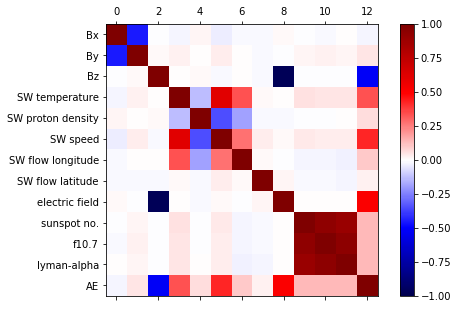

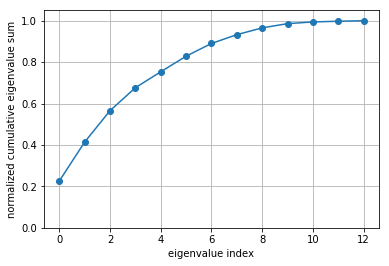

In [6]:
# compute correlations between variables
idx = np.ones(X.shape[0],dtype=bool)

for ii in range(nfeat):
    idx = np.all([idx, (X[X.columns[ii]] != nanvals[ii]).values],0)
    
cor = np.corrcoef(X[idx].T)

# compute eigenvalues
e = np.linalg.eig(cor)[0]
e = np.sort(e)[::-1]

# plot
fig, ax = plt.subplots(figsize=(8,5))
corplt = ax.matshow(cor, cmap=plt.get_cmap('seismic'))
ax.set_yticks(range(0,nfeat))
ax.set_yticklabels(feat)
plt.colorbar(corplt)
corplt.set_clim(-1,1)
#plt.savefig('../figures/linear_correlations.pdf', dpi=600, format='pdf')


plt.figure(figsize=(6,4))
plt.plot(np.cumsum(e)/np.sum(e),'o-')
plt.xlabel('eigenvalue index')
plt.ylabel('normalized cumulative eigenvalue sum')
plt.grid(True)
plt.ylim(0,1.05)
#plt.savefig('../figures/eval_spectrum.pdf', dpi=600, format='pdf')



Let's proceed by leveraging the fact that we have measurements of multiple datasets simultaneously. The fewest gaps occur in the measurements of the sunspot count, followed by the interplanetary magnetic field. We can use the simultaneous observed measurements of the IMF to predict the missing values. Then, once we have those missing values, we can move onto the next series with the fewest gaps, which is the f10.7 series. We can use the simultaneous measurements of the IMF, sunspot count, and the observed f10.7 measurements to predict the missing values of the f10.7 series. We progress like this through the remaining features, which are the solar wind (SW) speed and the proton density, in each step adding variables to the prediction.

## Gap filling with Neural Networks

The next step is to provide a simple proof of concept by filling gaps with a neural network trained on the available data. By doing so, I will gain familiarity with *tensorflow* & *pytorch* and provide a complete dataset that can be used in many other neural architectures.

### LSTM architecture

First, let's design a consistent LSTM architecture to apply to all of the data with gaps. This implementation is in Keras, and I also include serveral helper functions that will be useful for visualization and data-splitting.

We can use uninterrupted sequences of data to predict the values in the gaps. To this end, we will need to identify gaps in the data and isolate continuous sequences of data that we can split into training, validation, and testing datasets. Then, we'll start by filling in the gaps for the time series that have the fewest number of gaps (in this case, the IMF series). Once we've filled the gaps in the IMF series, we can use those data to help fill the gaps in the other series as well. Furthermore, for all time series we can use the series without gaps to help with estimation, which hopefully won't do much since ideally these time series all provide independent information. Still, it's good practice for me.

Thus, we'll always use
- sunspot number
- lyman-alpha
- AE

when gap filling.

The following dataframe will hold all of the data with the gaps filled, which I populate throughout the following sections.

In [7]:
# array to hold gap filled data (create only once)
Xgapsfilled = X.copy()

In [13]:
# Find sequences of a given value within an input vector. 
#
# IN:
# x: vector of values in which to find sequences
# val: scalar value to find sequences of in x
# noteq: (false) whether to find sequences equal or not equal to the supplied
#    value
#
# OUT:
# idx: array that contains in rows the number of total sequences of val, with 
#   the first column containing the begin indices of each sequence, the second 
#   column containing the end indices of sequences, and the third column 
#   contains the length of the sequence.
def findseq(x,val,noteq=False):
    x = x.copy().squeeze()
    assert len(x.shape) == 1, "x must be vector"
    # indices of value in x, and
    # compute differences of x, since subsequent occurences of val in x will 
    # produce zeros after differencing. append nonzero value at end to make 
    # x and difx the same size
    if noteq:
        validx = np.argwhere(x != val).squeeze()
        x[validx] = val+1
        difx = np.append(np.diff(x),1)
    else:
        validx = np.argwhere(x == val).squeeze()
        difx = np.append(np.diff(x),1)
    nval = len(validx)
    # if val not in x, warn user
    if nval == 0:
        warnings.warn("value val not found in x")
        return 0
    
    # now, where validx is one and difx is zero, we know that we have 
    # neighboring values of val in x. Where validx is one and difx is nonzero, 
    # we have end of a sequence
    
    # now loop over all occurrences of val in x and construct idx
    c1 = 0
    idx = np.empty((1,3))
    while c1 < nval:
        curidx = np.array([[validx[c1],validx[c1],1]])
        c2 = 0
        while difx[validx[c1]+c2] == 0:
            curidx[0,1] += 1
            curidx[0,2] += 1
            c2 += 1
        idx = np.append(idx,curidx,axis=0)
        c1 = c1+c2+1
    idx = idx[1:,:].astype(int)
    return idx


"""
depending on batch size and gaps in data, construct batches

IN: 
data: nd-array of data with shape (nobs, nfeatures)
dataidx: nd-array of beginning and end indices of data sequences in data with
    shape (nsequences,3) and columns (beg index, end index, length of sequence)
batch_size: integer of batch size to split data into

OUT:
batches: nd-array with size (nbatches*batch_size, 1, nfeatures), as required
   by keras; a more intuitive shape would be (nbatches, batch_size, nfeatures)

 """
def getbatches(data,dataidx, batch_size):
    assert dataidx.shape[1] == 3, 'dataidx must be correct shape'
    assert batch_size < np.max(dataidx[:,2]), \
         'at least one data sequence must be long enough for given batch_size'
    nseq = dataidx.shape[0]
    nfeatures = data.shape[1]
    # within each interval of data, split into largest possible number of 
    # batches with length batch_size
    X = np.zeros((batch_size, nfeatures))
    for ii in range(nseq):
        # skip this sequence if it is too short
        if dataidx[ii,2] < batch_size:
            continue
        nbatch = np.floor(dataidx[ii,2]/batch_size)
        curidx = np.arange(dataidx[ii,0],dataidx[ii,0]+int(nbatch*batch_size))
        curdat = data[curidx,:].reshape((int(nbatch*batch_size), nfeatures))
        X = np.append(X, curdat, axis=0)
    # remove first batch_size zeros at beginning
    X = X[batch_size:,:]
    return X


"""
From a data array with observations in rows and features in columns, split 
split into testing and training data based on which rows to use (datain_idx), 
batch_sizes, which features for prediction (incols) and which features as 
targest (outcols). Since we're concerned with time series forecasting, the 
number of steps to forecast ahead is lahead.

IN:
incols: index object with desired input column names 
outcols: index object with desired output column names 

OUT:

 """
def datasplit(data, datain_idx, batch_size, incols, outcols, \
              train_percent=0.8, lahead=1):
    nfeatin = len(incols)
    dataout_idx = datain_idx.copy()
    dataout_idx[:,0] = dataout_idx[:,0]+lahead
    dataout_idx[:,2] = dataout_idx[:,2]-lahead
    dat_in = getbatches(data[incols].values, 
                        datain_idx, 
                        batch_size).reshape(-1,1,nfeatin)
    dat_out = getbatches(data[outcols].values, 
                         dataout_idx, batch_size)
    nbatch = dat_in.shape[0]/batch_size
    # now construct training and testing sets
    trainbatch = np.random.permutation(int(nbatch))[0:int(0.8*nbatch)]
    trainidx = np.zeros(dat_in.shape[0],dtype=bool)
    for ii in range(trainbatch.shape[0]):
        curidx = np.arange(trainbatch[ii]*batch_size, \
                           trainbatch[ii]*batch_size+batch_size)
        trainidx[curidx] = True
    testidx  = np.logical_not(trainidx)
    
    dat_in_train = dat_in[trainidx,:,:]
    dat_out_train = dat_out[trainidx,:]
    dat_in_test = dat_in[testidx,:,:]
    dat_out_test = dat_out[testidx,:]
    return dat_in_train, dat_out_train, dat_in_test, dat_out_test

"""
Given a batch size and training data, train network on the data, and
return the trained network

IN:
dat_in_train (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_train (np.ndarray): data outputs with shape (ndata, nfeat_out)
batch_size (int/double):
nunits (int/double): (default 400) number of hidden units in LSTM
epochs (int): (default 100) epochs for training

OUT:
rnn (keras.Sequential): trained network
hist ()
"""
def train_network(dat_in_train, dat_out_train, batch_size, nunits=400, \
                  epochs=100):
    assert len(dat_in_train.shape) == 3, 'check shape of dat_in_train'
    assert len(dat_out_train.shape) == 2, 'check shape of dat_out_train'
    
    nfeat_in = dat_in_train.shape[2]
    nfeat_out = dat_out_train.shape[1]
    
    # recurrent architecture, create input and output datasets
    rnn = Sequential()
    
    rnn.add(LSTM(nunits, 
            name='LSTM_1',
            stateful=False,
            input_shape=(1,nfeat_in),
            batch_size=batch_size,
            return_sequences=False,
            activation='relu'))
    rnn.add(Dense(nfeat_out,
                  name='Dense'))
    opt = keras.optimizers.RMSprop()
    rnn.compile(loss='mse',optimizer=opt)
    # fit model
    hist = rnn.fit(dat_in_train,
            dat_out_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            verbose=0)
    return rnn, hist

"""
Given a trained network, evaluated it on testing data and plot the
scatter plots.

IN:
dat_in_test (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_test (np.ndarray): data outputs with shape (ndata, nfeat_out)
rnn (keras.Sequential): trained network
batch_size (int/double):
feature_names (list): list of names of output features, length nfeat_out

OUT:
produces plot

"""
def test_network(dat_in_test, dat_out_test, rnn, batch_size, feature_names):
    assert len(dat_in_test.shape) == 3, 'check shape of dat_in_test'
    assert len(dat_out_test.shape) == 2, 'check shape of dat_out_test'
    nfeat_out = dat_out_test.shape[1]
    rnn.reset_states()
    dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)
    for ii in range(nfeat_out):
        plt.figure()
        curtest = np.concatenate(([dat_out_test[:,0]],[dat_pred[:,0]])).T
        r2 = np.corrcoef(curtest[:,0],curtest[:,1])[0,1]**2
        plt.scatter(curtest[:,0],curtest[:,1])
        k = kde.gaussian_kde(curtest.T)
        x, y = curtest.T
        nbins = 40
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))                                      
        plt.contour(xi,yi,zi.reshape(xi.shape), 5)
        abline(1,0)
        plt.title('%s, $r^2$ = %1.2f' % (feature_names[ii], r2))
        plt.show()

"""
Plot straight line in current axis.
"""
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
    
"""
Gap filling.
"""
def fill_gaps(gapidx, rnn, batch_size):
    # use network to fill gaps in IMF data
    ngaps = gapidx.shape[0]

    for ii in range(ngaps):
        curgap = gapidx[ii,2]
        # if gap occurs before batch_size samples, just linearly interpolate
        if gapidx[ii,0] < batch_size:
            tcur = np.concatenate(([t[gapidx[ii,0]-1]],[t[gapidx[ii,1]+1]]))
            tquery = t[gapidx[ii,0]:gapidx[ii,1]+1]
            Xcur = np.concatenate((X.loc[gapidx[ii,0]-1,outcols],X.loc[gapidx[ii,1]+1,outcols]))
            Xgapsfilled.loc[gapidx[ii,0]:gapidx[ii,1]+1, outcols] = np.interp(tquery, tcur, Xcur)
        # otherwise, let's use the trained network
        else:
            for jj in range(curgap):
                cur_in = Xgapsfilled[gapidx[ii,0]+jj-batch_size:gapidx[ii,0]+jj][incols].values
                cur_in = cur_in.reshape(-1,1,nfeatin)
                rnn.reset_states()
                cur_pred = rnn.predict(cur_in,batch_size=batch_size)
                Xgapsfilled.loc[gapidx[ii,0]+jj, outcols] = cur_pred[-1,:]

### IMF

Let's start with the IMF data. 

In [9]:
# we want network to predict next value
lahead = 1
# let's work with batches
batch_size = 1000 # in hours

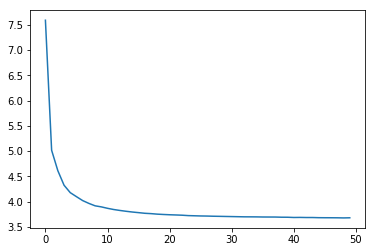

In [10]:
# indices of uninterrupted data sequences
datain_idx = findseq(X['By, nT (GSM)'],nanvals.loc['By, nT (GSM)'],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, AE-index as input
incols = X.columns[[0,1,2,9,11,12]]
outcols = X.columns[[0,1,2]]
nfeatin = len(incols)
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.9,
              lahead=lahead)

# trained network
rnn, hist = train_network(dat_in_train, dat_out_train, batch_size, epochs=50)
plt.plot(hist.history['loss'])

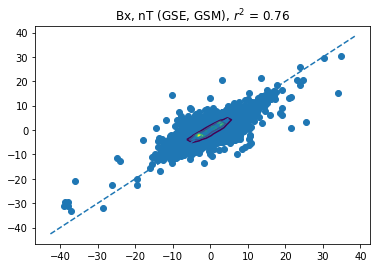

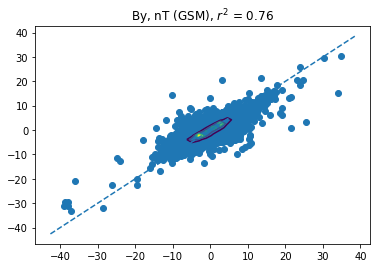

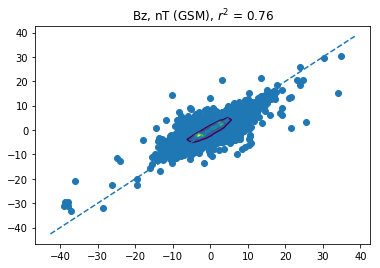

In [14]:
test_network(dat_in_test, dat_out_test, rnn, batch_size, outcols)

# gaps for IMF data
gapidx = findseq(X['By, nT (GSM)'],nanvals.loc['By, nT (GSM)'])
fill_gaps(gapidx, rnn, batch_size)

### f10.7

Now let's fill the gaps in the f10.7 data.

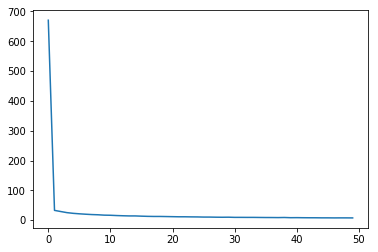

In [15]:
# indices of uninterrupted data sequences
datain_idx = findseq(X['f10.7-index'],nanvals.loc['f10.7-index'],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, AE-index, and previous f10.7 as input
incols = Xgapsfilled.columns[[0,1,2,9,10,11,12]]
outcols = X.columns[[10]]
nfeatin = len(incols)
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)

# trained network
rnn, hist = train_network(dat_in_train, dat_out_train, batch_size, epochs=50)
plt.plot(hist.history['loss'])

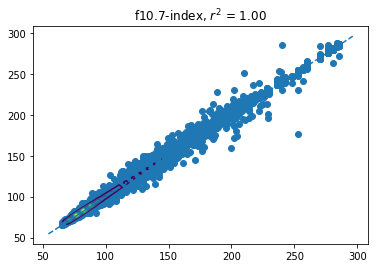

In [16]:
test_network(dat_in_test, dat_out_test, rnn, batch_size, outcols)

# gaps for IMF data
gapidx = findseq(X['f10.7-index'],nanvals.loc['f10.7-index'])
fill_gaps(gapidx, rnn, batch_size)

### SW speed

Next is solar wind speed

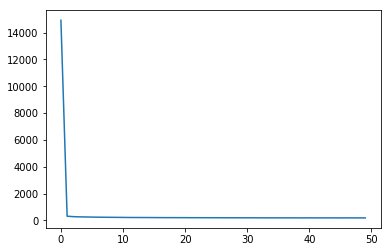

In [17]:
# indices of uninterrupted data sequences
datain_idx = findseq(X['SW plasma speed, km/s'],nanvals.loc['SW plasma speed, km/s'],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, AE-index, f10.7, and previous speed measurements as input
incols = Xgapsfilled.columns[[0,1,2,5,9,10,11,12]]
outcols = X.columns[[5]]
nfeatin = len(incols)
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)

# trained network
rnn, hist = train_network(dat_in_train, dat_out_train, batch_size, epochs=50)
plt.plot(hist.history['loss'])

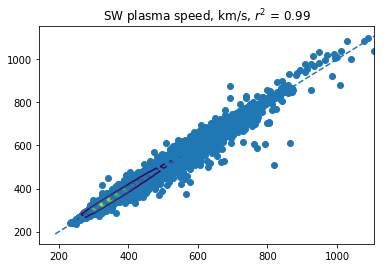

In [18]:
test_network(dat_in_test, dat_out_test, rnn, batch_size, outcols)

# gaps for IMF data
gapidx = findseq(X['SW plasma speed, km/s'],nanvals.loc['SW plasma speed, km/s'])
fill_gaps(gapidx, rnn, batch_size)

### SW flow longitude

The next time series is the flow longitude angle for the solar wind.

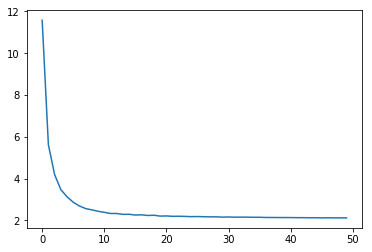

In [19]:
# indices of uninterrupted data sequences
datain_idx = findseq(X['SW plasma flow long. angle'],nanvals.loc['SW plasma flow long. angle'],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, AE-index, f10.7, SW speed, and previous flow longitude measurements as input
incols = Xgapsfilled.columns[[0,1,2,5,6,9,10,11,12]]
outcols = X.columns[[6]]
nfeatin = len(incols)
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)

# trained network
rnn, hist = train_network(dat_in_train, dat_out_train, batch_size, epochs=50)
plt.plot(hist.history['loss'])

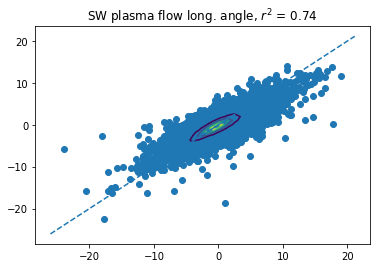

In [20]:
test_network(dat_in_test, dat_out_test, rnn, batch_size, outcols)

# gaps for IMF data
gapidx = findseq(X['SW plasma flow long. angle'],nanvals.loc['SW plasma flow long. angle'])
fill_gaps(gapidx, rnn, batch_size)

### SW flow latitude

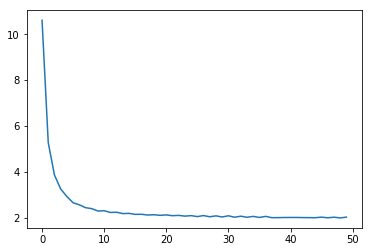

In [21]:
# indices of uninterrupted data sequences
datain_idx = findseq(X['SW plasma flow lat. angle'],nanvals.loc['SW plasma flow lat. angle'],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, AE-index, f10.7, SW speed, SW longitude, and previous flow latitude measurements as input
incols = Xgapsfilled.columns[[0,1,2,5,6,7,9,10,11,12]]
outcols = X.columns[[7]]
nfeatin = len(incols)
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)

# trained network
rnn, hist = train_network(dat_in_train, dat_out_train, batch_size, epochs=50)
plt.plot(hist.history['loss'])

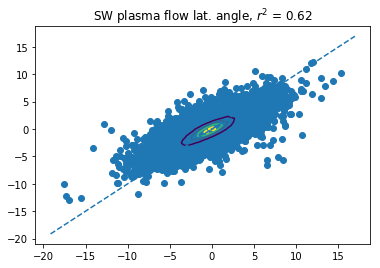

In [22]:
test_network(dat_in_test, dat_out_test, rnn, batch_size, outcols)

# gaps for IMF data
gapidx = findseq(X['SW plasma flow lat. angle'],nanvals.loc['SW plasma flow lat. angle'])
fill_gaps(gapidx, rnn, batch_size)

### Electric field

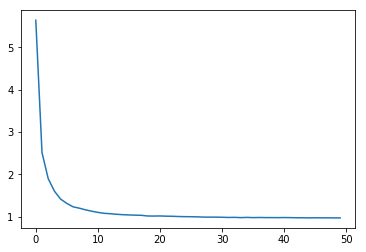

In [23]:
# indices of uninterrupted data sequences
datain_idx = findseq(X['electric field'],nanvals.loc['electric field'],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, AE-index, f10.7, SW speed, SW longitude, SW latitude, and previous electric field measurements as input
incols = Xgapsfilled.columns[[0,1,2,5,6,7,8,9,10,11,12]]
outcols = X.columns[[8]]
nfeatin = len(incols)
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)

# trained network
rnn, hist = train_network(dat_in_train, dat_out_train, batch_size, epochs=50)
plt.plot(hist.history['loss'])

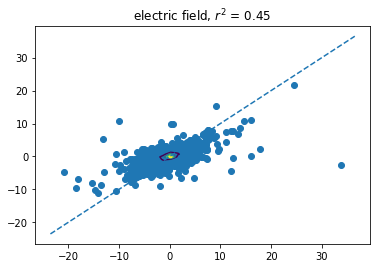

In [24]:
test_network(dat_in_test, dat_out_test, rnn, batch_size, outcols)

# gaps for IMF data
gapidx = findseq(X['electric field'],nanvals.loc['electric field'])
fill_gaps(gapidx, rnn, batch_size)

### Plasma temperature

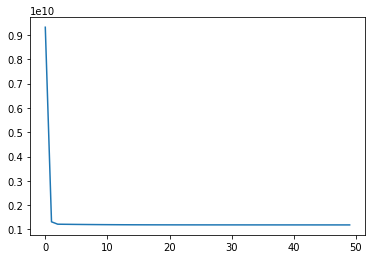

In [25]:
# indices of uninterrupted data sequences
datain_idx = findseq(X['SW plasma temperature, K'],nanvals.loc['SW plasma temperature, K'],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, AE-index, f10.7, SW speed, SW longitude, SW latitude, electric field, and previous SW temperature measurements as input
incols = Xgapsfilled.columns[[0,1,2,3,5,6,7,8,9,10,11,12]]
outcols = X.columns[[3]]
nfeatin = len(incols)
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)

# trained network
rnn, hist = train_network(dat_in_train, dat_out_train, batch_size, epochs=50)
plt.plot(hist.history['loss'])

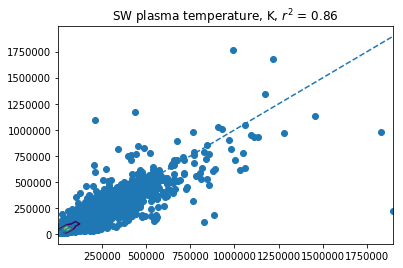

In [26]:
test_network(dat_in_test, dat_out_test, rnn, batch_size, outcols)

# gaps for IMF data
gapidx = findseq(X['SW plasma temperature, K'],nanvals.loc['SW plasma temperature, K'])
fill_gaps(gapidx, rnn, batch_size)

### Solar wind proton density

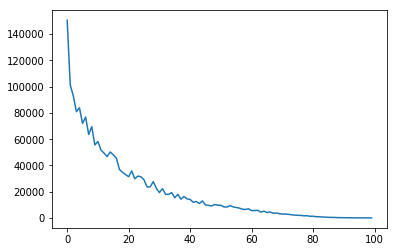

In [27]:
# indices of uninterrupted data sequences
datain_idx = findseq(X['SW proton density, N/cm^3'],nanvals.loc['SW proton density, N/cm^3'],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, AE-index, f10.7, SW speed, SW longitude, SW latitude, electric field, and previous SW temperature measurements as input
incols = Xgapsfilled.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12]]
outcols = X.columns[[4]]
nfeatin = len(incols)
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)

# trained network
rnn, hist = train_network(dat_in_train, dat_out_train, batch_size, epochs=100)
plt.plot(hist.history['loss'])

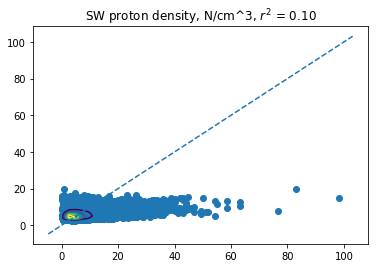

In [28]:
test_network(dat_in_test, dat_out_test, rnn, batch_size, outcols)

# gaps for IMF data
gapidx = findseq(X['SW proton density, N/cm^3'],nanvals.loc['SW proton density, N/cm^3'])
fill_gaps(gapidx, rnn, batch_size)

## Save interpolated data

Now having filled all the gaps, let's save the data in a new hdf file.

In [39]:
fl = []
fls = os.listdir('../OMNI_data')
for s in fls:
    fl.append('omni_hourly_1998-2017_nogaps.h5' == s)

if not any(fl):
    Xgapsfilled.to_hdf('../OMNI_data/omni_hourly_1998-2017_nogaps.h5','data')